In [1]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0, 1]

# Expand dimensions to make them compatible with the VGG-like architecture
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Define the model
model = Sequential()

# Block 1: Convolutional layers with ReLU activation and MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Block 2: Convolutional layers with ReLU activation and MaxPooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output to feed into fully connected layers
model.add(Flatten())

# Fully Connected Layers with ReLU activation
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer with Softmax activation (for classification)
model.add(Dense(10, activation='softmax'))  # 10 classes for digits 0-9

# Compile the model
model.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [3]:
# Train the model
model.fit(x_train, y_train, epochs=4, batch_size=64, validation_data=(x_test, y_test))
model.save('VGG16_MNIST.h5')

Epoch 1/4
938/938 [==============================] - 159s 169ms/step - loss: 0.1773 - accuracy: 0.9451 - val_loss: 0.0356 - val_accuracy: 0.9883
Epoch 2/4
938/938 [==============================] - 159s 169ms/step - loss: 0.0536 - accuracy: 0.9847 - val_loss: 0.0253 - val_accuracy: 0.9923
Epoch 3/4
938/938 [==============================] - 156s 166ms/step - loss: 0.0380 - accuracy: 0.9891 - val_loss: 0.0252 - val_accuracy: 0.9923
Epoch 4/4
938/938 [==============================] - 143s 152ms/step - loss: 0.0312 - accuracy: 0.9912 - val_loss: 0.0210 - val_accuracy: 0.9942


In [7]:
model = load_model('VGG16_MNIST.h5')

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

# Summary of the model architecture
model.summary()

313/313 [==============================] - 6s 18ms/step - loss: 0.0210 - accuracy: 0.9942
Test accuracy: 0.9941999912261963
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                

In [4]:
_, baseline_model_accuracy = model.evaluate(
    x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                               final_sparsity=0.30,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()


logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

# # Access and print the pruned weight matrices
matrix_2nd=[[[]]];
f=0
for layer in model_for_export.trainable_weights:
    print(f'Layer: {layer.name}, Shape: {layer.shape}')
    # print(layer.numpy())
    if(f==0):
       matrix_2nd.clear();
       f+=1;
    matrix_2nd.append(layer.numpy())

# Save the pruned model to a file
model_for_export.save('Pruned_VGG16_MNIST.h5')

Baseline test accuracy: 0.9941999912261963
Saved baseline model to: C:\Users\sahoo\AppData\Local\Temp\tmps56td3ez.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 64)       1218      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 24, 24, 64)       73794     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 12, 12, 64)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 10, 10, 128)      147586    
 2 (PruneLowMagnitude)                                           
     

INFO:tensorflow:Assets written to: C:\Users\sahoo\AppData\Local\Temp\tmp5132dxkk\assets


INFO:tensorflow:Assets written to: C:\Users\sahoo\AppData\Local\Temp\tmp5132dxkk\assets


Saved pruned TFLite model to: C:\Users\sahoo\AppData\Local\Temp\tmp0syb_nat.tflite
Size of gzipped baseline Keras model: 5845761.00 bytes
Size of gzipped pruned Keras model: 4606089.00 bytes
Size of gzipped pruned TFlite model: 4601433.00 bytes
Layer: conv2d/kernel:0, Shape: (3, 3, 1, 64)
Layer: conv2d/bias:0, Shape: (64,)
Layer: conv2d_1/kernel:0, Shape: (3, 3, 64, 64)
Layer: conv2d_1/bias:0, Shape: (64,)
Layer: conv2d_2/kernel:0, Shape: (3, 3, 64, 128)
Layer: conv2d_2/bias:0, Shape: (128,)
Layer: conv2d_3/kernel:0, Shape: (3, 3, 128, 128)
Layer: conv2d_3/bias:0, Shape: (128,)
Layer: dense/kernel:0, Shape: (2048, 512)
Layer: dense/bias:0, Shape: (512,)
Layer: dense_1/kernel:0, Shape: (512, 512)
Layer: dense_1/bias:0, Shape: (512,)
Layer: dense_2/kernel:0, Shape: (512, 10)
Layer: dense_2/bias:0, Shape: (10,)


RANDOM INITIALISATION OF CENTROIDS
WCSS for k = 1 is 4.142523765563965
WCSS for k = 2 is 1.8636656999588013
WCSS for k = 3 is 0.622115433216095
WCSS for k = 4 is 0.3381764888763428
WCSS for k = 5 is 0.22479555010795593
WCSS for k = 6 is 0.14212211966514587
WCSS for k = 7 is 0.22761723399162292
WCSS for k = 8 is 0.07737865298986435
WCSS for k = 9 is 0.13940273225307465
WCSS for k = 10 is 0.047253694385290146
WCSS for k = 11 is 0.045963581651449203
WCSS for k = 12 is 0.047102682292461395
WCSS for k = 13 is 0.028250781819224358
WCSS for k = 14 is 0.042131491005420685
WCSS for k = 15 is 0.02391989342868328
WCSS for k = 16 is 0.020093096420168877
WCSS for k = 17 is 0.018082905560731888
WCSS for k = 18 is 0.026650983840227127
WCSS for k = 19 is 0.01578093320131302


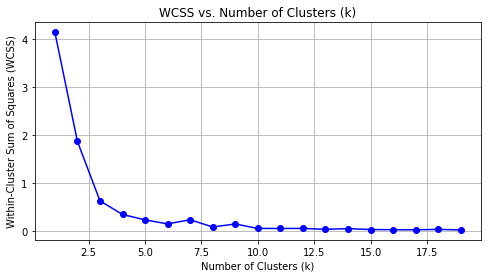

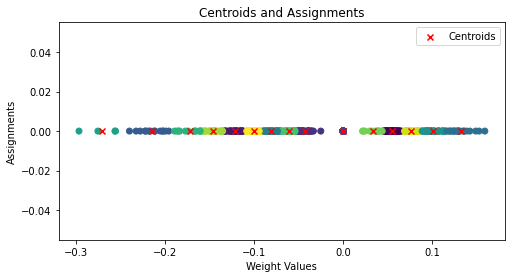

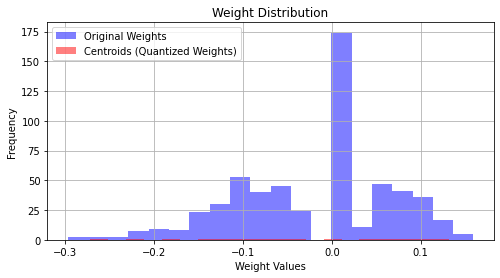

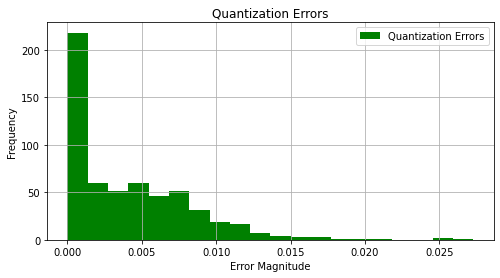

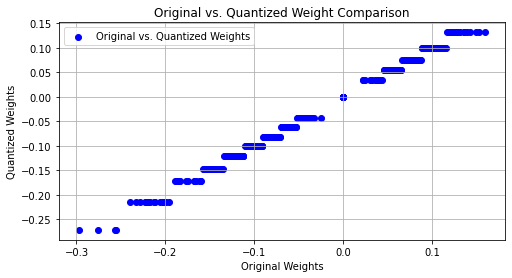

DENSITY BASED INITIALISATION OF CENTROIDS
WCSS for k = 1 is 4.142523765563965
WCSS for k = 2 is 1.302160620689392
WCSS for k = 3 is 0.6223607659339905
WCSS for k = 4 is 0.33822256326675415
WCSS for k = 5 is 0.2252139449119568
WCSS for k = 6 is 0.17389406263828278
WCSS for k = 7 is 0.09117699414491653
WCSS for k = 8 is 0.07737865298986435
WCSS for k = 9 is 0.06488573551177979
WCSS for k = 10 is 0.04643736034631729
WCSS for k = 11 is 0.03905276954174042
WCSS for k = 12 is 0.03644109517335892
WCSS for k = 13 is 0.03618820756673813
WCSS for k = 14 is 0.02893771603703499
WCSS for k = 15 is 0.025759808719158173
WCSS for k = 16 is 0.021631110459566116
WCSS for k = 17 is 0.019454805180430412
WCSS for k = 18 is 0.017183080315589905
WCSS for k = 19 is 0.015828583389520645


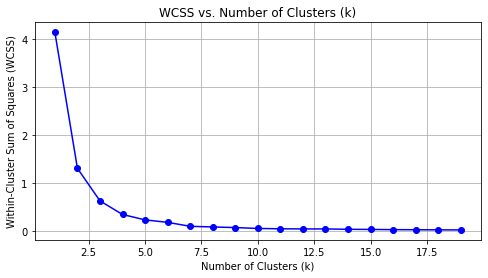

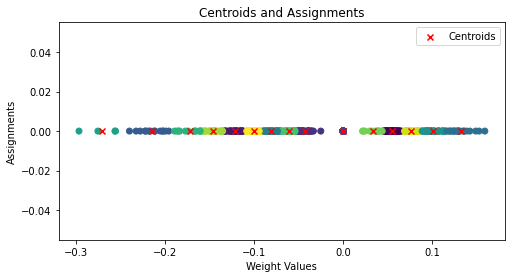

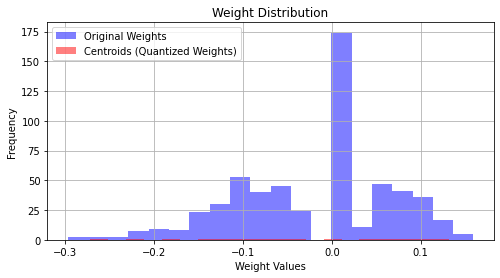

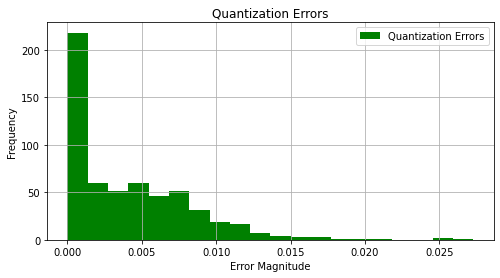

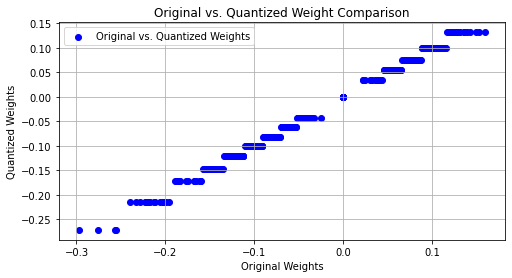

LINEAR BASED INITIALISATION OF CENTROIDS
WCSS for k = 1 is 4.142523765563965
WCSS for k = 2 is 1.302160620689392
WCSS for k = 3 is 0.622115433216095
WCSS for k = 4 is 0.3381764888763428
WCSS for k = 5 is 0.2249457985162735
WCSS for k = 6 is 0.14222875237464905
WCSS for k = 7 is 0.09117699414491653
WCSS for k = 8 is 0.07736729085445404
WCSS for k = 9 is 0.05961911007761955
WCSS for k = 10 is 0.05531620606780052
WCSS for k = 11 is 0.0439101941883564
WCSS for k = 12 is 0.03636481612920761
WCSS for k = 13 is 0.031025942414999008
WCSS for k = 14 is 0.031073953956365585
WCSS for k = 15 is 0.023852510377764702
WCSS for k = 16 is 0.021378707140684128
WCSS for k = 17 is 0.019116470590233803
WCSS for k = 18 is 0.016899893060326576
WCSS for k = 19 is 0.01396572683006525


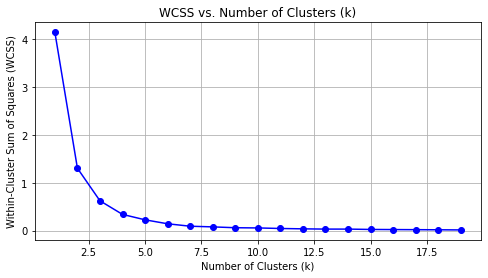

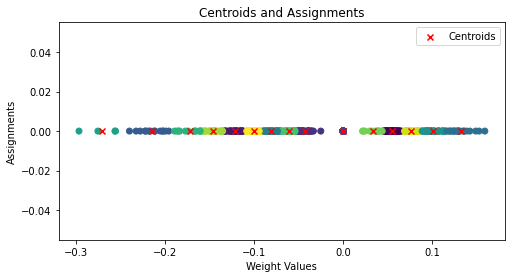

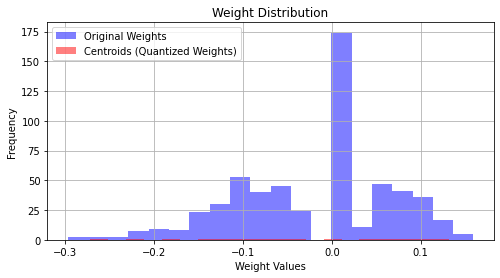

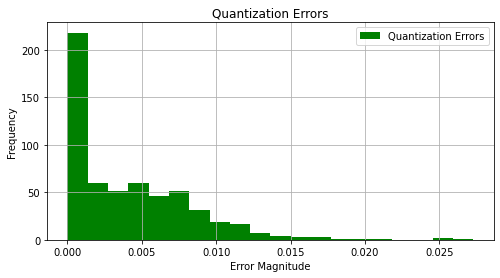

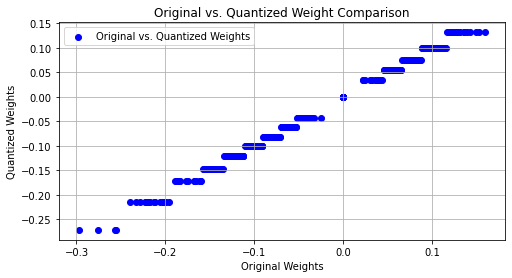

[[[[-0.0451588   0.08331108  0.05143496 -0.10743628 -0.
    -0.         -0.         -0.10894828 -0.         -0.10650301
     0.1490411  -0.07584219  0.05610865 -0.          0.07277373
    -0.04930471  0.          0.13875794  0.07147493 -0.03835135
     0.04938404  0.          0.0741723   0.08960135  0.
     0.          0.02179016  0.1008362   0.          0.05036922
     0.          0.12859255 -0.10219696 -0.         -0.
     0.09263561 -0.          0.09439426 -0.0953484  -0.
    -0.06526617 -0.09111047 -0.05620804  0.04522536 -0.
    -0.10509196 -0.05830831 -0.08018149  0.09432612 -0.04579518
    -0.10923741 -0.05078788  0.         -0.04010436 -0.08377527
    -0.05754869  0.          0.         -0.05291867  0.
     0.         -0.16507447  0.         -0.14454475]]

  [[ 0.07561306  0.12414761 -0.05594125  0.05117719 -0.10464372
     0.09848619 -0.05170295 -0.12843284  0.0799915   0.10214088
    -0.12637776 -0.03582037 -0.         -0.          0.11190592
    -0.04588694  0.0575818   0.05

In [8]:
import numpy as np
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
# matrix_1st matrix_2nd
# Define centroid initialization methods
def random_init(X, k):
    # Randomly choose k observations from the data set as initial centroids
    initial_centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    return initial_centroids

def density_based_init(X, k):
    # Linearly space the CDF of the data and find the corresponding quantiles
    percentiles = np.linspace(0, 100, k + 2)[1:-1]
    initial_centroids = np.percentile(X, percentiles)
    return initial_centroids

def linear_init(X, k):
    # Linearly space the centroids between the min and max values of the data
    initial_centroids = np.linspace(np.min(X), np.max(X), k)
    return initial_centroids

# Custom initialization wrapper
def custom_init(X, k, method):
    if method == 'random':
        return random_init(X, k)
    elif method == 'density_based':
        return density_based_init(X, k)
    elif method == 'linear':
        return linear_init(X, k)
    else:
        raise ValueError("Invalid centroid initialization method")

# Step 3: Implement weight sharing using K-means clustering with WCSS for k selection
def weight_sharing_with_optimal_k(layer_weights, centroid_init_method='random'):
    # Reshape the weights into a 1D array

    flattened_weights = layer_weights.flatten()

    # Initialize a list to store WCSS values for different values of k
    wcss = []

    # Define a range of values for k (number of clusters)
    k_values = range(1, 20)  # You can adjust the range as needed

    # Calculate WCSS for each k
    for k in k_values:
        # Use the custom_init wrapper to select the initialization method
        initial_centroids = custom_init(flattened_weights.reshape(-1, 1), k, centroid_init_method)
        kmeans = KMeans(n_clusters=k, random_state=0, init=initial_centroids.reshape(-1, 1))
        kmeans.fit(flattened_weights.reshape(-1, 1))
        wcss.append(kmeans.inertia_)
        print('WCSS for k = '+ str(k)+' is ' + str(kmeans.inertia_))


    # Plot the WCSS values to select the optimal k
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
    plt.title('WCSS vs. Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid()
    plt.show()

    # Choose the optimal k (e.g., by visually inspecting the elbow point)
    optimal_k = 15 # Replace with your chosen optimal k

    # Apply K-means clustering with the chosen optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans.fit(flattened_weights.reshape(-1, 1))

    # Get cluster assignments for each weight
    cluster_assignments = kmeans.predict(flattened_weights.reshape(-1, 1))

    # Create shared centroids
    centroids = kmeans.cluster_centers_.flatten()

    # Reshape cluster assignments back to the original shape
    shared_weights = centroids[cluster_assignments].reshape(layer_weights.shape)

    # Plot centroids and their assignments
    plt.figure(figsize=(8, 4))
    plt.scatter(flattened_weights, np.zeros_like(flattened_weights), c=cluster_assignments, cmap='viridis')
    plt.scatter(centroids, np.zeros_like(centroids), c='red', marker='x', label='Centroids')
    plt.title('Centroids and Assignments')
    plt.xlabel('Weight Values')
    plt.ylabel('Assignments')
    plt.legend()
    plt.show()

        # Plot weight distribution histogram
    plt.figure(figsize=(8, 4))
    plt.hist(flattened_weights, bins=20, alpha=0.5, color='blue', label='Original Weights')
    plt.hist(centroids, bins=20, alpha=0.5, color='red', label='Centroids (Quantized Weights)')
    plt.title('Weight Distribution')
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate errors between original weights and quantized centroids
    quantization_errors = np.abs(flattened_weights - centroids[cluster_assignments])

    # Plot error distribution histogram
    plt.figure(figsize=(8, 4))
    plt.hist(quantization_errors, bins=20, color='green', label='Quantization Errors')
    plt.title('Quantization Errors')
    plt.xlabel('Error Magnitude')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()


    # Plot original vs. quantized weight comparison
    plt.figure(figsize=(8, 4))
    plt.scatter(flattened_weights, centroids[cluster_assignments], color='blue', label='Original vs. Quantized Weights')
    plt.title('Original vs. Quantized Weight Comparison')
    plt.xlabel('Original Weights')
    plt.ylabel('Quantized Weights')
    plt.legend()
    plt.grid()
    plt.show()





    return shared_weights, centroids

# Step 4: Quantize the weights and store them in shared centroids
def quantize_weights(layer_weights, centroids):
    # Quantize the weights by finding the closest centroid for each weight
    quantized_weights = centroids[np.argmin(np.abs(layer_weights.reshape(-1, 1) - centroids), axis=1)]

    # Reshape quantized weights back to the original shape
    quantized_weights = quantized_weights.reshape(layer_weights.shape)

    return quantized_weights

# Step 6: During inference, use the shared centroids for forward propagation
def forward_propagation(input_data, shared_weights):
    output = np.dot(input_data, shared_weights)
    return output

input_size = 5
hidden_size = 5

layer_weights=matrix_2nd[0]


print("RANDOM INITIALISATION OF CENTROIDS")

shared_weights_random, centroids_random = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='random')


print("DENSITY BASED INITIALISATION OF CENTROIDS")

# Density-based initialization
shared_weights_density, centroids_density = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='density_based')


print("LINEAR BASED INITIALISATION OF CENTROIDS")
# Linear initialization
shared_weights_linear, centroids_linear = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='linear')

print(layer_weights)
print(shared_weights_linear)

In [9]:
import numpy as np
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
centroids=[];
quantized_weights=[];
# matrix_1st matrix_2nd
# Define centroid initialization methods
def random_init(X, k):
    # Randomly choose k observations from the data set as initial centroids
    initial_centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    return initial_centroids

def density_based_init(X, k):
    # Linearly space the CDF of the data and find the corresponding quantiles
    percentiles = np.linspace(0, 100, k + 2)[1:-1]
    initial_centroids = np.percentile(X, percentiles)
    return initial_centroids

def linear_init(X, k):
    # Linearly space the centroids between the min and max values of the data
    initial_centroids = np.linspace(np.min(X), np.max(X), k)
    return initial_centroids

# Custom initialization wrapper
def custom_init(X, k, method):
    if method == 'random':
        return random_init(X, k)
    elif method == 'density_based':
        return density_based_init(X, k)
    elif method == 'linear':
        return linear_init(X, k)
    else:
        raise ValueError("Invalid centroid initialization method")

# Step 3: Implement weight sharing using K-means clustering with WCSS for k selection
def weight_sharing_with_optimal_k(layer_weights, centroid_init_method='random'):
    # Reshape the weights into a 1D array

    flattened_weights = layer_weights.flatten()

    # Initialize a list to store WCSS values for different values of k
    wcss = []

    # Define a range of values for k (number of clusters)
    k_values = range(1, 20)  # You can adjust the range as needed

    # Calculate WCSS for each k
    for k in k_values:
        # Use the custom_init wrapper to select the initialization method
        initial_centroids = custom_init(flattened_weights.reshape(-1, 1), k, centroid_init_method)
        kmeans = KMeans(n_clusters=k, random_state=0, init=initial_centroids.reshape(-1, 1))
        kmeans.fit(flattened_weights.reshape(-1, 1))
        wcss.append(kmeans.inertia_)

    # Choose the optimal k (e.g., by visually inspecting the elbow point)
    optimal_k = 15 # Replace with your chosen optimal k

    # Apply K-means clustering with the chosen optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans.fit(flattened_weights.reshape(-1, 1))

    # Get cluster assignments for each weight
    cluster_assignments = kmeans.predict(flattened_weights.reshape(-1, 1))

    # Create shared centroids
    centroids = kmeans.cluster_centers_.flatten()

    # Reshape cluster assignments back to the original shape
    shared_weights = centroids[cluster_assignments].reshape(layer_weights.shape)


    return shared_weights, centroids

# Step 4: Quantize the weights and store them in shared centroids
def quantize_weights(layer_weights, centroids):
    # Quantize the weights by finding the closest centroid for each weight
    quantized_weights = centroids[np.argmin(np.abs(layer_weights.reshape(-1, 1) - centroids), axis=1)]

    # Reshape quantized weights back to the original shape
    quantized_weights = quantized_weights.reshape(layer_weights.shape)

    return quantized_weights

# Step 6: During inference, use the shared centroids for forward propagation
def forward_propagation(input_data, shared_weights):
    output = np.dot(input_data, shared_weights)
    return output

for matrix in matrix_2nd:
  layer_weights=np.array(matrix)

  if(layer_weights.size<=20):
    continue;

  print(layer_weights.shape)
  # Linear initialization
  shared_weights_linear, centroids_linear = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='linear')
  centroids.append(centroids_linear);
  quantized_weights.append(shared_weights_linear);
  # print(layer_weights)
  # print(shared_weights_linear)
print(centroids)
print(quantized_weights)

(3, 3, 1, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(2048, 512)
(512,)
(512, 512)
(512,)
(512, 10)
[array([ 5.47204912e-02, -1.21517345e-01, -4.33494747e-02, -1.67638063e-08,
       -2.15216726e-01,  1.31934524e-01, -8.14313293e-02,  1.00480147e-01,
       -2.71362633e-01, -1.72229767e-01, -6.08056635e-02,  3.39548178e-02,
       -1.46106005e-01,  7.59897977e-02, -1.00037113e-01], dtype=float32), array([-0.0232798 ,  0.0124712 , -0.06488282, -0.00420272, -0.04776282,
       -0.01722246,  0.03222027, -0.0812526 ,  0.00649988,  0.02116092,
       -0.03484266, -0.01034793, -0.05450395,  0.00126286, -0.04266953],
      dtype=float32), array([-5.2454650e-02,  7.2713606e-02, -1.5091790e-01, -4.1237101e-05,
        1.3029279e-01,  3.2509424e-02, -9.5072955e-02,  1.8978524e-01,
       -2.4845494e-01, -7.2444543e-02,  5.2024536e-02, -3.3097416e-02,
       -1.8916363e-01,  9.7120218e-02, -1.2094483e-01], dtype=float32), array([-0.01587065,  0.01403535,  0.0472

In [10]:
file_path = "VGG16_MNIST.txt"

with open(file_path, "w") as file:
    for row in quantized_weights:
        # Convert each element to a string and join them with spaces
        row_str = " ".join(map(str, row))

        # Write the row to the file
        file.write(row_str + "\n")

In [11]:
quantized_weights_flatten=[]
for i in quantized_weights:
    quantized_weights_flatten.append(i.flatten())

In [12]:
# print(len(shared_weights_density_flatten_list))
strings=[]
for j in range(len(quantized_weights_flatten)):
    s=""
    for i in range(len(quantized_weights_flatten[j])):
        if(quantized_weights_flatten[j][i]==centroids[j][0]):
            s = s+"A"
        if(quantized_weights_flatten[j][i]==centroids[j][1]):
            s = s+"B"
        if(quantized_weights_flatten[j][i]==centroids[j][2]):
            s = s+"C"
        if(quantized_weights_flatten[j][i]==centroids[j][3]):
            s = s+"D"
        if(quantized_weights_flatten[j][i]==centroids[j][4]):
            s = s+"E"
        if(quantized_weights_flatten[j][i]==centroids[j][5]):
            s = s+"F"
        if(quantized_weights_flatten[j][i]==centroids[j][6]):
            s = s+"G"
        if(quantized_weights_flatten[j][i]==centroids[j][7]):
            s = s+"H"
        if(quantized_weights_flatten[j][i]==centroids[j][8]):
            s = s+"I"
        if(quantized_weights_flatten[j][i]==centroids[j][9]):
            s = s+"J"
        if(quantized_weights_flatten[j][i]==centroids[j][10]):
            s = s+"K"
        if(quantized_weights_flatten[j][i]==centroids[j][11]):
            s = s+"L"
        if(quantized_weights_flatten[j][i]==centroids[j][12]):
            s = s+"M"
        if(quantized_weights_flatten[j][i]==centroids[j][13]):
            s = s+"N"
        if(quantized_weights_flatten[j][i]==centroids[j][14]):
            s = s+"O"
    strings.append(s)

print(strings)

['CNAODDDODOFGADNCDFNCADNHDDLHDADFODDHDHODKOKADOKGHCOCDCGKDDKDDJDMNFKAOHCBNHBCDDHCAABMGKNKCABDDFACDDDAADHAADBHMIHBKDOFMBCNAKNDDCDAACHOGBDGLDJDHDDDODDCOADGDBDDBHBHGLCCBJONDDADBLHODKODDDOODONOHDGHCCMGCGODCBCHJDDDDKKBHDDFAADHHADCNKLDENCDKKHKAHJGDDDEHDDNDHGDGAAOADANDECKBJNFEDCODKADOMDJGMDGDDEDDONCJMDHDNDMDOBADDCBDNDFDCAKDFDDDAKNLDDMJLIKBBDKDDGDCODBDKKHGACCDADMGDOOAKDBOIODEGLADHFDOBNODDMDMNDLHGDMDNDDFDMHDMDDDHGDKNDOHBEDDBABDEHEDDGNGFONDDGHHDNDDDMNODMHOODAMDOBHONDDDMAACDONOBMADAGDMKBJDGIOCKEDDADNDJOEKAMAEKBGDBDLENHOJJNLFDHANODDDCLDDDOAKFFDNDNDKFMGKDCHDKOGCNFDMMHKODEGDGNGFDFDODO', 'OKIEKNFNOENFLCJFHJCFAALLCFMADLGBFMHGINDIHEOEDJBIILELDLICFDLJANCA', 'FGDLGBDDNBLNCLDDMGJCFDFFFDDFBBKABBDLFDDLDDJJBKBDDDDADKDDAKDKLLNJCDOAKLJLJJAFJDEOLADCDAAMAFGDFDLADLDOGDDGDADGFDNJGOGDKDAHBFAOCDACKGNLCGIDAJBLLJEDLODFDDNENJNDBODOAKNGDEJDDBDBGEDDODBOELOGBBADJLDDDJDLDDFALKCKDAKDAJDJDNBLGAIKDDJAJLKOCIFODFDJDDDJKDDDCDKDDADKBJKGOLCDDNBGDDLDFDCCDLABADOODLGDDFODAFDDLGGDJBLAGLLBDDGKABDDBDBFGDGOAKLLBCDADDJCDLLDGLGDGDCEDDDDDJ

In [13]:
from collections import Counter, namedtuple

# Define a named tuple to represent a Huffman tree node
HuffmanNode = namedtuple("HuffmanNode", ["char", "freq", "left", "right"])

# Function to build the Huffman tree
def build_huffman_tree(text):
    char_freq = Counter(text)
    priority_queue = [HuffmanNode(char, freq, None, None) for char, freq in char_freq.items()]
    while len(priority_queue) > 1:
        priority_queue.sort(key=lambda node: node.freq)
        left = priority_queue.pop(0)
        right = priority_queue.pop(0)
        merged_node = HuffmanNode(None, left.freq + right.freq, left, right)
        priority_queue.append(merged_node)
    return priority_queue[0]

# Function to generate Huffman codes
def generate_huffman_codes(root, current_code="", code_dict=None):
    if code_dict is None:
        code_dict = {}
    if root.char is not None:
        code_dict[root.char] = current_code
    if root.left is not None:
        generate_huffman_codes(root.left, current_code + "0", code_dict)
    if root.right is not None:
        generate_huffman_codes(root.right, current_code + "1", code_dict)
    return code_dict

# Function to perform Huffman encoding
def huffman_encode(text):
    root = build_huffman_tree(text)
    code_dict = generate_huffman_codes(root)
    encoded_text = "".join(code_dict[char] for char in text)
    return encoded_text, root

# Function to perform Huffman decoding
def huffman_decode(encoded_text, root):
    decoded_text = ""
    current_node = root
    for bit in encoded_text:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.char is not None:
            decoded_text += current_node.char
            current_node = root

    return decoded_text

# text = s
# encoded_text, tree = huffman_encode(text)
# decoded_text = huffman_decode(encoded_text, tree)

# print("Original text:", text)
# print("Encoded text:", encoded_text)
# print("Decoded text:", decoded_text)

In [14]:
# Encode all the matrixes
encoded_texts=[]
huffman_tree=[]
for i in range(len(quantized_weights)):
    encoded_text,tree = huffman_encode(strings[i])
    encoded_texts.append(encoded_text)
    huffman_tree.append(tree)

In [15]:
# For VGG 16 on MNIST dataset
file_path = "VGG16_MNIST_huffman.txt"

with open("VGG16_MNIST_huffman.txt", "w") as file:
    for row in encoded_texts:
        # Write the row to the file
        file.write(row + "\n")

In [16]:
import h5py
import numpy as np

# Define the input text file and output HDF5 file names
input_txt_file = "VGG16_MNIST_huffman.txt"
output_h5_file = "VGG16_MNIST_huffman.h5"

# Read data from the text file (assuming each line contains a numerical value)
with open(input_txt_file, "r") as txt_file:
    data = [float(line.strip()) for line in txt_file]

# Convert the data to a NumPy array
data_array = np.array(data)

# Create an HDF5 file and save the data
with h5py.File(output_h5_file, "w") as h5_file:
    h5_file.create_dataset("data", data=data_array)

In [17]:
file_path_5 = "VGG16_MNIST.h5"  # Replace with the path to your file
file_size_5 = os.path.getsize(file_path_5)
print(f"The size of '{file_path_5}' is {file_size_5} bytes")

file_path_5 = "Pruned_VGG16_MNIST.h5"
file_size_5 = os.path.getsize(file_path_5)
print(f"The size of '{file_path_5}' is {file_size_5} bytes")

file_path_6 = "VGG16_MNIST_huffman.h5"
file_size_6 = os.path.getsize(file_path_6)
print(f"The size of '{file_path_6}' is {file_size_6} bytes")

The size of 'VGG16_MNIST.h5' is 18981320 bytes
The size of 'Pruned_VGG16_MNIST.h5' is 6339960 bytes
The size of 'VGG16_MNIST_huffman.h5' is 2152 bytes
